In [22]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression

In [23]:
sql_context = SQLContext(sc)
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/input/data.csv')
data.take(1)

[Row(ID=1, LIMIT_BAL=20000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=24, PAY_0=2, PAY_2=2, PAY_3=-1, PAY_4=-1, PAY_5=-2, PAY_6=-2, BILL_AMT1=3913, BILL_AMT2=3102, BILL_AMT3=689, BILL_AMT4=0, BILL_AMT5=0, BILL_AMT6=0, PAY_AMT1=0, PAY_AMT2=689, PAY_AMT3=0, PAY_AMT4=0, PAY_AMT5=0, PAY_AMT6=0, default payment next month=1)]

In [24]:
type(data)

pyspark.sql.dataframe.DataFrame

In [25]:
data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- default payment next month: inte

In [26]:
data.toPandas().head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [27]:
data = data.withColumnRenamed("default payment next month", "label")

## EDA 

In [28]:
data.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [29]:
# traget value distribution :
data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 6636|
|    0|23364|
+-----+-----+



## Distibution of Features

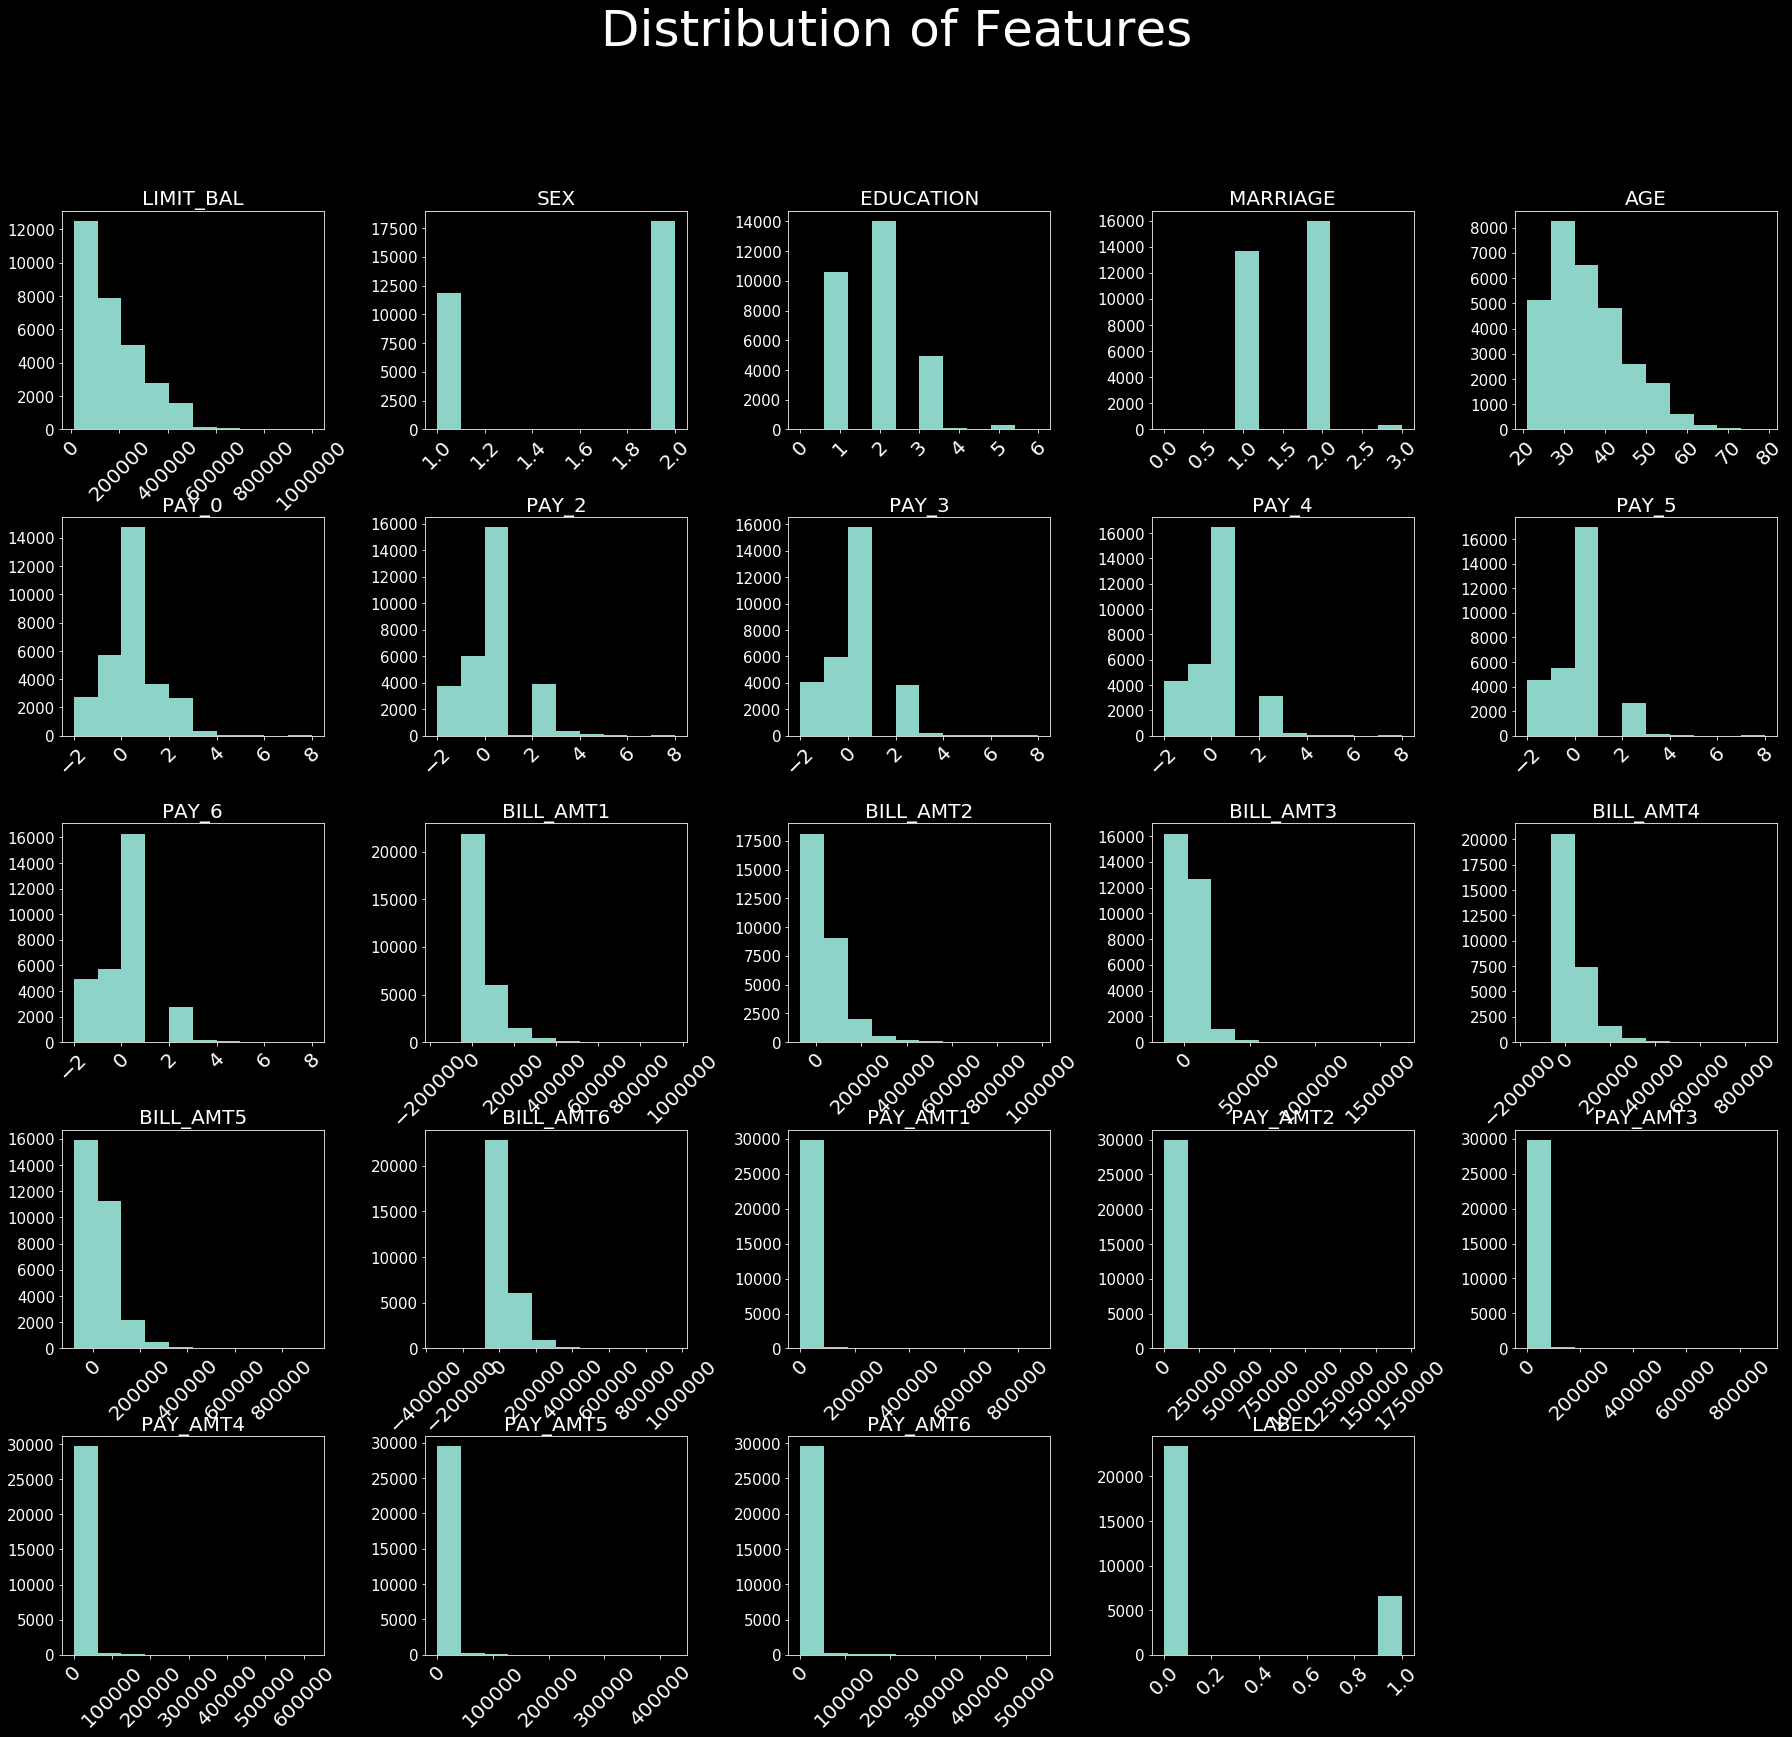

In [30]:

fig = plt.figure(figsize=(25, 25))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment='center') 

for col,num in zip(data.toPandas().describe().columns[1:], range(1,25)):
    ax = fig.add_subplot(5,5,num)
    ax.hist(data.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

In [31]:
# NULL values 

from pyspark.sql.functions import isnan, when, count, col
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).toPandas().head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
columns = data.columns
columns = columns[:-1]

In [33]:
assembler = VectorAssembler(inputCols=columns, outputCol="features")
assembler = assembler.transform(data)
assembler.toPandas().head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,label,features
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,"[1.0, 20000.0, 2.0, 2.0, 1.0, 24.0, ..."
1,2,120000,2,2,2,26,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,"[2.0, 120000.0, 2.0, 2.0, 2.0, 26.0,..."
2,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,"[3.0, 90000.0, 2.0, 2.0, 2.0, 34.0, ..."
3,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,"[4.0, 50000.0, 2.0, 2.0, 1.0, 37.0, ..."
4,5,50000,1,2,1,57,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,"[5.0, 50000.0, 1.0, 2.0, 1.0, 57.0, ..."


In [34]:
scaler = StandardScaler().setInputCol("features").setOutputCol("scaler_features")
scaler = scaler.fit(assembler)
scaler = scaler.transform(assembler)
pd.set_option('display.max_colwidth', 40)
scaler.select("scaler_features","features").toPandas().head(5)

,scaler_features,features
0,"[0.00011546812938513904, 0.154145359...","[1.0, 20000.0, 2.0, 2.0, 1.0, 24.0, ..."
1,"[0.00023093625877027807, 0.924872159...","[2.0, 120000.0, 2.0, 2.0, 2.0, 26.0,..."
2,"[0.0003464043881554171, 0.6936541199...","[3.0, 90000.0, 2.0, 2.0, 2.0, 34.0, ..."
3,"[0.00046187251754055615, 0.385363399...","[4.0, 50000.0, 2.0, 2.0, 1.0, 37.0, ..."
4,"[0.0005773406469256952, 0.3853633999...","[5.0, 50000.0, 1.0, 2.0, 1.0, 57.0, ..."


In [35]:
train, test = scaler.randomSplit([0.7, 0.3])
print("train size: {}\ntest size: {}".format(train.count(), test.count()))

train size: 21023
test size: 8977


In [36]:
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 4651|
|    0|16372|
+-----+-----+



In [37]:
model_lr = LogisticRegression(featuresCol='scaler_features', labelCol="label", maxIter=5)
model = model_lr.fit(train)
prediction = model.transform(test)

prediction.select('label', 'scaler_features', 'prediction', 'probability').toPandas().head(5)

,label,scaler_features,prediction,probability
0,0,"[0.0003464043881554171, 0.6936541199...",0.0,"[0.7528485393412229, 0.2471514606587..."
1,0,"[0.00046187251754055615, 0.385363399...",0.0,"[0.7470479124925181, 0.2529520875074..."
2,0,"[0.0006928087763108342, 0.3853633999...",0.0,"[0.7539354195828843, 0.2460645804171..."
3,0,"[0.0010392131644662514, 1.0790175199...",0.0,"[0.7245239511617773, 0.2754760488382..."
4,0,"[0.0011546812938513903, 0.1541453599...",0.0,"[0.9100601498949792, 0.0899398501050..."


In [38]:
accuracy = prediction.filter(prediction.label == prediction.prediction).count() / float(prediction.count())
print("Accuracy : ",accuracy)

Accuracy :  0.7994875793694999


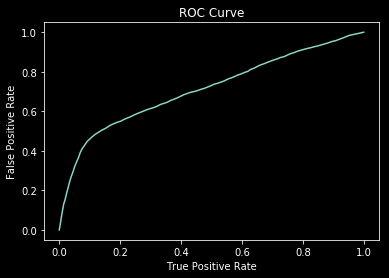

Training set areaUnderROC: 0.7116753157335338


In [39]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(prediction))

Test Area Under ROC 0.7153234859270625


# Tuning

In [41]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(model_lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(model_lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(model_lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=model_lr, estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)

In [42]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', evaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.7236536970643676
